# **Model Implementation**

MobileNetV3-Small

In [3]:
from datasets import load_dataset
from huggingface_hub import login
import os
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import gc

print("Streaming dataset...")
ds_stream = load_dataset("saberzl/SID_Set", split="train", streaming=True)

# Step 3: Setup directories for 3 classes
save_dir = "/content/sid_images"
os.makedirs(f"{save_dir}/real", exist_ok=True)
os.makedirs(f"{save_dir}/synthetic", exist_ok=True)
os.makedirs(f"{save_dir}/tampered", exist_ok=True)

target_per_class = 3600
class_counts = {'real': 0, 'synthetic': 0, 'tampered': 0}

print(f"Downloading {target_per_class} images per class (Real, Synthetic, Tampered)...")
print("Saving images directly to disk to avoid memory issues\n")

pbar = tqdm(ds_stream)
for sample in pbar:
    # Get label (0=Real, 1=Synthetic, 2=Tampered)
    label = sample.get('label', sample.get('class', None))

    if label is None:
        print(f"Available keys: {sample.keys()}")
        break

    # Map label to class name
    if label == 0:
        class_name = 'real'
    elif label == 1:
        class_name = 'synthetic'
    elif label == 2:
        class_name = 'tampered'
    else:
        continue

    if class_counts[class_name] >= target_per_class:
        if all(count >= target_per_class for count in class_counts.values()):
            print("\n Downloaded target number for all classes!")
            break
        continue

    if 'image' in sample:
        img = sample['image']
        if isinstance(img, Image.Image):
            class_counts[class_name] += 1
            img_filename = f"{class_name}_{class_counts[class_name]:05d}.png"
            img_path = f"{save_dir}/{class_name}/{img_filename}"

            # Convert all images to RGB (handles RGBA, CMYK, L, etc.)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Save as PNG
            img.save(img_path, 'PNG')
            img.close()

            # Update progress bar
            pbar.set_description(
                f"Real: {class_counts['real']}/{target_per_class} | "
                f"Synth: {class_counts['synthetic']}/{target_per_class} | "
                f"Tamp: {class_counts['tampered']}/{target_per_class}"
            )

            # Force garbage collection every 100 images
            if sum(class_counts.values()) % 100 == 0:
                gc.collect()

pbar.close()

print(f"\n{'='*70}")
print(f"Download Complete!")
print(f"{'='*70}")
print(f"Real images:      {class_counts['real']}")
print(f"Synthetic images: {class_counts['synthetic']}")
print(f"Tampered images:  {class_counts['tampered']}")
print(f"Total images:     {sum(class_counts.values())}")
print(f"Images saved to:  {save_dir}")
print(f"{'='*70}")

# Step 4: Create PyTorch Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load real images (label 0)
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images (label 1)
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images (label 2)
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        print(f"\nDataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label



Streaming dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Saving images directly to disk to avoid memory issues



Real: 1412/3600 | Synth: 1400/3600 | Tamp: 1408/3600: : 4220it [32:24,  2.17it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: d316419c-fefc-4d47-95f4-8cb09566a3bb)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00005-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 2005/3600 | Synth: 1926/3600 | Tamp: 1984/3600: : 5915it [45:20,  1.38it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f694743b-e452-46cb-949f-55acda05b717)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00007-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 3600/3600 | Synth: 3600/3600 | Tamp: 3600/3600: : 10858it [1:22:20,  2.20it/s]



 Downloaded target number for all classes!

Download Complete!
Real images:      3600
Synthetic images: 3600
Tampered images:  3600
Total images:     10800
Images saved to:  /content/sid_images


In [4]:
!pip install torch torchvision tqdm pillow -q

# Importing librarires

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

#Configuration

In [6]:


class Config:
    # Paths
    data_dir = '/content/sid_images'
    save_dir = './checkpoints'

    # Model
    backbone = 'mobilenet_v3_small'
    pretrained = True
    num_classes = 3

    # Training
    epochs = 20
    batch_size = 32
    lr = 1e-4
    weight_decay = 1e-4
    num_workers = 2


    save_freq = 5
    seed = 42

config = Config()

#random seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print("Configuration loaded!")
print(f"Data directory: {config.data_dir}")
print(f"Save directory: {config.save_dir}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")



Configuration loaded!
Data directory: /content/sid_images
Save directory: ./checkpoints
Device: CPU


#Dataset Class

In [7]:
class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load real images
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        # Split into train/val
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        split_idx = int(0.8 * len(self.samples))

        if split == 'train':
            indices = indices[:split_idx]
        else:
            indices = indices[split_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")

Dataset class defined!


#Model Definition

In [8]:
class SimpleSIDA(nn.Module):
    def __init__(self, num_classes=3, backbone='mobilenet_v3_small', pretrained=True):
        super(SimpleSIDA, self).__init__()
        from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

        if pretrained:
            self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        else:
            self.backbone = mobilenet_v3_small(weights=None)

        self.feature_dim = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Identity()  # remove original classifier

        self.cls_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.cls_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.cls_head(features)
        return logits


In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

print("Training function defined!")

Training function defined!


In [10]:
def validate(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    num_classes = 3
    confusion_matrix = torch.zeros(num_classes, num_classes)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]")
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.cpu(), predicted.cpu()):
                confusion_matrix[t.long(), p.long()] += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    class_names = ['Real', 'Synthetic', 'Tampered']
    per_class_metrics = {}

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        total_class = confusion_matrix[i, :].sum()
        class_acc = float(tp / total_class) if total_class > 0 else 0.0
        precision = float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0
        recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        per_class_metrics[class_names[i]] = {
            'accuracy': class_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    print(f"\n{'='*60}")
    print(f"Validation Results (Epoch {epoch+1}):")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Average Loss: {avg_loss:.4f}")
    print("\nPer-Class Metrics:")
    for class_name, metrics in per_class_metrics.items():
        print(f"\n{class_name}:")
        print(f"  Accuracy:  {metrics['accuracy']*100:.2f}%")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1:        {metrics['f1']:.4f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}", end="")
    for name in class_names:
        print(f"{name:>12}", end="")
    print()
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12}", end="")
        for j in range(num_classes):
            print(f"{int(confusion_matrix[i, j]):>12}", end="")
        print()
    print(f"{'='*60}\n")

    return avg_loss, accuracy, per_class_metrics, confusion_matrix

print("Validation function defined!")



Validation function defined!


In [11]:
def plot_training_history(results, save_path):
    """Plot training history"""
    epochs = [r['epoch'] for r in results]
    train_losses = [r['train_loss'] for r in results]
    val_losses = [r['val_loss'] for r in results]
    train_accs = [r['train_acc'] for r in results]
    val_accs = [r['val_acc'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_accs, label='Train Acc', marker='o')
    ax2.plot(epochs, val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_confusion_matrix(cm, save_path):
    """Plot confusion matrix"""
    class_names = ['Real', 'Synthetic', 'Tampered']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.numpy(), annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Final Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

print("Visualization functions defined!")



Visualization functions defined!


#Creating Datasets and Dataloaders

In [12]:
class SIDDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load images by class
        class_dirs = {'real': 0, 'synthetic': 1, 'tampered': 2}
        for cls_name, cls_label in class_dirs.items():
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.exists(cls_dir):
                for img_name in sorted(os.listdir(cls_dir)):
                    if img_name.endswith('.png'):
                        self.samples.append((os.path.join(cls_dir, img_name), cls_label))

        # Shuffle indices
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))

        # Split 70% train, 15% val, 15% test
        n = len(self.samples)
        train_idx = int(0.7 * n)
        val_idx = int(0.85 * n)

        if split == 'train':
            indices = indices[:train_idx]
        elif split == 'val':
            indices = indices[train_idx:val_idx]
        else:  # test
            indices = indices[val_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [13]:
# Transforms
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Datasets
train_dataset = SIDDataset(config.data_dir, transform=train_transform, split='train')
val_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='val')
test_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='test')

# Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")



Train Dataset Statistics:
  Real: 2537
  Synthetic: 2533
  Tampered: 2489
  Total: 7559 images

Val Dataset Statistics:
  Real: 522
  Synthetic: 523
  Tampered: 576
  Total: 1621 images

Test Dataset Statistics:
  Real: 541
  Synthetic: 544
  Tampered: 535
  Total: 1620 images
Train batches: 237, Val batches: 51, Test batches: 51


#Initialize Model, Loss, Optimizer

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Create model
print("Creating model...")
model = SimpleSIDA(num_classes=config.num_classes,
                   backbone=config.backbone,
                   pretrained=config.pretrained)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

print("\nModel, loss, and optimizer initialized!")


Using device: cpu
Creating model...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 79.6MB/s]


Total parameters: 1,223,971
Trainable parameters: 1,223,971

Model, loss, and optimizer initialized!


# **Model Training**

In [15]:
print(f"\n{'='*70}")
print(f"Starting Training")
print(f"{'='*70}")
print(f"Total epochs: {config.epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.lr}")
print(f"{'='*70}\n")

best_acc = 0.0
results = []

for epoch in range(config.epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc, per_class_metrics, cm = validate(
        model, val_loader, criterion, device, epoch
    )

    scheduler.step()

    # Save results
    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'per_class_metrics': per_class_metrics
    })

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, os.path.join(config.save_dir, 'best_model.pth'))
        print(f"✓ New best model saved! Accuracy: {val_acc:.2f}%\n")

    # Save periodic checkpoint
    if (epoch + 1) % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# Save final model
torch.save({
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
}, os.path.join(config.save_dir, 'final_model.pth'))

# Save results as JSON
with open(os.path.join(config.save_dir, 'training_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n{'='*70}")
print(f"Training Completed!")
print(f"Best Validation Accuracy: {best_acc:.2f}%")
print(f"Models saved to: {config.save_dir}")
print(f"{'='*70}\n")



Starting Training
Total epochs: 20
Batch size: 32
Learning rate: 0.0001



Epoch 1 [Train]:   0%|          | 0/237 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1 [Val]: 100%|██████████| 51/51 [01:21<00:00,  1.59s/it, loss=0.5781, acc=77.91%]



Validation Results (Epoch 1):
Overall Accuracy: 77.91%
Average Loss: 0.4755

Per-Class Metrics:

Real:
  Accuracy:  57.09%
  Precision: 0.7395
  Recall:    0.5709
  F1:        0.6443

Synthetic:
  Accuracy:  99.24%
  Precision: 0.8842
  Recall:    0.9924
  F1:        0.9351

Tampered:
  Accuracy:  77.43%
  Precision: 0.7068
  Recall:    0.7743
  F1:        0.7390

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 298          40         184
Synthetic              3         519           1
Tampered             102          28         446

✓ New best model saved! Accuracy: 77.91%



Epoch 2 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.48s/it, loss=0.5323, acc=79.58%]



Validation Results (Epoch 2):
Overall Accuracy: 79.58%
Average Loss: 0.4765

Per-Class Metrics:

Real:
  Accuracy:  69.54%
  Precision: 0.7319
  Recall:    0.6954
  F1:        0.7132

Synthetic:
  Accuracy:  99.81%
  Precision: 0.8628
  Recall:    0.9981
  F1:        0.9255

Tampered:
  Accuracy:  70.31%
  Precision: 0.7788
  Recall:    0.7031
  F1:        0.7391

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 363          44         115
Synthetic              1         522           0
Tampered             132          39         405

✓ New best model saved! Accuracy: 79.58%



Epoch 3 [Val]: 100%|██████████| 51/51 [01:16<00:00,  1.50s/it, loss=0.3955, acc=81.86%]



Validation Results (Epoch 3):
Overall Accuracy: 81.86%
Average Loss: 0.3822

Per-Class Metrics:

Real:
  Accuracy:  85.82%
  Precision: 0.6819
  Recall:    0.8582
  F1:        0.7600

Synthetic:
  Accuracy:  96.56%
  Precision: 0.9806
  Recall:    0.9656
  F1:        0.9730

Tampered:
  Accuracy:  64.93%
  Precision: 0.8330
  Recall:    0.6493
  F1:        0.7298

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 448           3          71
Synthetic             14         505           4
Tampered             195           7         374

✓ New best model saved! Accuracy: 81.86%



Epoch 4 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.49s/it, loss=0.3509, acc=84.02%]



Validation Results (Epoch 4):
Overall Accuracy: 84.02%
Average Loss: 0.3449

Per-Class Metrics:

Real:
  Accuracy:  82.38%
  Precision: 0.7363
  Recall:    0.8238
  F1:        0.7776

Synthetic:
  Accuracy:  97.90%
  Precision: 0.9827
  Recall:    0.9790
  F1:        0.9808

Tampered:
  Accuracy:  72.92%
  Precision: 0.8140
  Recall:    0.7292
  F1:        0.7692

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 430           1          91
Synthetic              6         512           5
Tampered             148           8         420

✓ New best model saved! Accuracy: 84.02%



Epoch 5 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.46s/it, loss=0.3910, acc=81.49%]



Validation Results (Epoch 5):
Overall Accuracy: 81.49%
Average Loss: 0.4247

Per-Class Metrics:

Real:
  Accuracy:  85.82%
  Precision: 0.6924
  Recall:    0.8582
  F1:        0.7665

Synthetic:
  Accuracy:  99.81%
  Precision: 0.9158
  Recall:    0.9981
  F1:        0.9552

Tampered:
  Accuracy:  60.94%
  Precision: 0.8688
  Recall:    0.6094
  F1:        0.7163

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 448          21          53
Synthetic              1         522           0
Tampered             198          27         351



Epoch 6 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.48s/it, loss=0.3564, acc=83.34%]



Validation Results (Epoch 6):
Overall Accuracy: 83.34%
Average Loss: 0.3753

Per-Class Metrics:

Real:
  Accuracy:  84.87%
  Precision: 0.7111
  Recall:    0.8487
  F1:        0.7738

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9594
  Recall:    0.9943
  F1:        0.9765

Tampered:
  Accuracy:  67.36%
  Precision: 0.8509
  Recall:    0.6736
  F1:        0.7519

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 443          12          67
Synthetic              2         520           1
Tampered             178          10         388



Epoch 7 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.47s/it, loss=0.3686, acc=81.12%]



Validation Results (Epoch 7):
Overall Accuracy: 81.12%
Average Loss: 0.4417

Per-Class Metrics:

Real:
  Accuracy:  89.85%
  Precision: 0.6606
  Recall:    0.8985
  F1:        0.7614

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9700
  Recall:    0.9904
  F1:        0.9801

Tampered:
  Accuracy:  56.94%
  Precision: 0.8700
  Recall:    0.5694
  F1:        0.6884

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 469           6          47
Synthetic              3         518           2
Tampered             238          10         328



Epoch 8 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.49s/it, loss=0.3286, acc=83.34%]



Validation Results (Epoch 8):
Overall Accuracy: 83.34%
Average Loss: 0.3950

Per-Class Metrics:

Real:
  Accuracy:  78.35%
  Precision: 0.7343
  Recall:    0.7835
  F1:        0.7581

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9665
  Recall:    0.9924
  F1:        0.9792

Tampered:
  Accuracy:  73.44%
  Precision: 0.8027
  Recall:    0.7344
  F1:        0.7670

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 409          10         103
Synthetic              3         519           1
Tampered             145           8         423



Epoch 9 [Val]: 100%|██████████| 51/51 [01:13<00:00,  1.45s/it, loss=0.3633, acc=83.22%]



Validation Results (Epoch 9):
Overall Accuracy: 83.22%
Average Loss: 0.4318

Per-Class Metrics:

Real:
  Accuracy:  84.29%
  Precision: 0.7085
  Recall:    0.8429
  F1:        0.7699

Synthetic:
  Accuracy:  98.85%
  Precision: 0.9792
  Recall:    0.9885
  F1:        0.9838

Tampered:
  Accuracy:  68.06%
  Precision: 0.8305
  Recall:    0.6806
  F1:        0.7481

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 440           4          78
Synthetic              4         517           2
Tampered             177           7         392



Epoch 10 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.47s/it, loss=0.3320, acc=82.42%]



Validation Results (Epoch 10):
Overall Accuracy: 82.42%
Average Loss: 0.4447

Per-Class Metrics:

Real:
  Accuracy:  81.42%
  Precision: 0.7095
  Recall:    0.8142
  F1:        0.7583

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9540
  Recall:    0.9904
  F1:        0.9719

Tampered:
  Accuracy:  68.23%
  Precision: 0.8205
  Recall:    0.6823
  F1:        0.7450

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 425          13          84
Synthetic              3         518           2
Tampered             171          12         393



Epoch 11 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.47s/it, loss=0.2472, acc=82.48%]



Validation Results (Epoch 11):
Overall Accuracy: 82.48%
Average Loss: 0.4639

Per-Class Metrics:

Real:
  Accuracy:  83.72%
  Precision: 0.6970
  Recall:    0.8372
  F1:        0.7607

Synthetic:
  Accuracy:  98.09%
  Precision: 0.9884
  Recall:    0.9809
  F1:        0.9846

Tampered:
  Accuracy:  67.19%
  Precision: 0.8147
  Recall:    0.6719
  F1:        0.7364

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 437           3          82
Synthetic              4         513           6
Tampered             186           3         387



Epoch 12 [Val]: 100%|██████████| 51/51 [01:20<00:00,  1.59s/it, loss=0.2576, acc=83.10%]



Validation Results (Epoch 12):
Overall Accuracy: 83.10%
Average Loss: 0.4663

Per-Class Metrics:

Real:
  Accuracy:  80.08%
  Precision: 0.7257
  Recall:    0.8008
  F1:        0.7614

Synthetic:
  Accuracy:  98.28%
  Precision: 0.9735
  Recall:    0.9828
  F1:        0.9781

Tampered:
  Accuracy:  72.05%
  Precision: 0.8027
  Recall:    0.7205
  F1:        0.7594

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 418           7          97
Synthetic              4         514           5
Tampered             154           7         415



Epoch 13 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.46s/it, loss=0.2588, acc=82.67%]



Validation Results (Epoch 13):
Overall Accuracy: 82.67%
Average Loss: 0.4827

Per-Class Metrics:

Real:
  Accuracy:  81.61%
  Precision: 0.7088
  Recall:    0.8161
  F1:        0.7587

Synthetic:
  Accuracy:  97.90%
  Precision: 0.9846
  Recall:    0.9790
  F1:        0.9818

Tampered:
  Accuracy:  69.79%
  Precision: 0.8040
  Recall:    0.6979
  F1:        0.7472

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 426           4          92
Synthetic              5         512           6
Tampered             170           4         402



Epoch 14 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.48s/it, loss=0.2891, acc=82.97%]



Validation Results (Epoch 14):
Overall Accuracy: 82.97%
Average Loss: 0.5035

Per-Class Metrics:

Real:
  Accuracy:  82.57%
  Precision: 0.7100
  Recall:    0.8257
  F1:        0.7635

Synthetic:
  Accuracy:  98.47%
  Precision: 0.9828
  Recall:    0.9847
  F1:        0.9838

Tampered:
  Accuracy:  69.27%
  Precision: 0.8143
  Recall:    0.6927
  F1:        0.7486

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 431           4          87
Synthetic              4         515           4
Tampered             172           5         399



Epoch 15 [Val]: 100%|██████████| 51/51 [01:17<00:00,  1.53s/it, loss=0.3048, acc=83.16%]



Validation Results (Epoch 15):
Overall Accuracy: 83.16%
Average Loss: 0.5237

Per-Class Metrics:

Real:
  Accuracy:  83.72%
  Precision: 0.7083
  Recall:    0.8372
  F1:        0.7673

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9756
  Recall:    0.9924
  F1:        0.9839

Tampered:
  Accuracy:  68.06%
  Precision: 0.8305
  Recall:    0.6806
  F1:        0.7481

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 437           6          79
Synthetic              3         519           1
Tampered             177           7         392



Epoch 16 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.47s/it, loss=0.3050, acc=82.97%]



Validation Results (Epoch 16):
Overall Accuracy: 82.97%
Average Loss: 0.5029

Per-Class Metrics:

Real:
  Accuracy:  79.12%
  Precision: 0.7233
  Recall:    0.7912
  F1:        0.7557

Synthetic:
  Accuracy:  98.47%
  Precision: 0.9810
  Recall:    0.9847
  F1:        0.9828

Tampered:
  Accuracy:  72.40%
  Precision: 0.7943
  Recall:    0.7240
  F1:        0.7575

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 413           5         104
Synthetic              4         515           4
Tampered             154           5         417



Epoch 17 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.46s/it, loss=0.2967, acc=83.16%]



Validation Results (Epoch 17):
Overall Accuracy: 83.16%
Average Loss: 0.5125

Per-Class Metrics:

Real:
  Accuracy:  80.65%
  Precision: 0.7221
  Recall:    0.8065
  F1:        0.7620

Synthetic:
  Accuracy:  98.28%
  Precision: 0.9828
  Recall:    0.9828
  F1:        0.9828

Tampered:
  Accuracy:  71.70%
  Precision: 0.8019
  Recall:    0.7170
  F1:        0.7571

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 421           4          97
Synthetic              4         514           5
Tampered             158           5         413



Epoch 18 [Val]: 100%|██████████| 51/51 [01:15<00:00,  1.48s/it, loss=0.3030, acc=83.22%]



Validation Results (Epoch 18):
Overall Accuracy: 83.22%
Average Loss: 0.5155

Per-Class Metrics:

Real:
  Accuracy:  80.46%
  Precision: 0.7216
  Recall:    0.8046
  F1:        0.7609

Synthetic:
  Accuracy:  98.66%
  Precision: 0.9810
  Recall:    0.9866
  F1:        0.9838

Tampered:
  Accuracy:  71.70%
  Precision: 0.8051
  Recall:    0.7170
  F1:        0.7585

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 420           5          97
Synthetic              4         516           3
Tampered             158           5         413



Epoch 19 [Val]: 100%|██████████| 51/51 [01:17<00:00,  1.52s/it, loss=0.2943, acc=83.16%]



Validation Results (Epoch 19):
Overall Accuracy: 83.16%
Average Loss: 0.5180

Per-Class Metrics:

Real:
  Accuracy:  80.46%
  Precision: 0.7204
  Recall:    0.8046
  F1:        0.7602

Synthetic:
  Accuracy:  98.66%
  Precision: 0.9829
  Recall:    0.9866
  F1:        0.9847

Tampered:
  Accuracy:  71.53%
  Precision: 0.8031
  Recall:    0.7153
  F1:        0.7567

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 420           4          98
Synthetic              4         516           3
Tampered             159           5         412



Epoch 20 [Val]: 100%|██████████| 51/51 [01:14<00:00,  1.47s/it, loss=0.2915, acc=83.28%]



Validation Results (Epoch 20):
Overall Accuracy: 83.28%
Average Loss: 0.5199

Per-Class Metrics:

Real:
  Accuracy:  81.23%
  Precision: 0.7211
  Recall:    0.8123
  F1:        0.7640

Synthetic:
  Accuracy:  98.47%
  Precision: 0.9810
  Recall:    0.9847
  F1:        0.9828

Tampered:
  Accuracy:  71.35%
  Precision: 0.8091
  Recall:    0.7135
  F1:        0.7583

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 424           5          93
Synthetic              4         515           4
Tampered             160           5         411


Training Completed!
Best Validation Accuracy: 84.02%
Models saved to: ./checkpoints



#Plot

Generating plots...


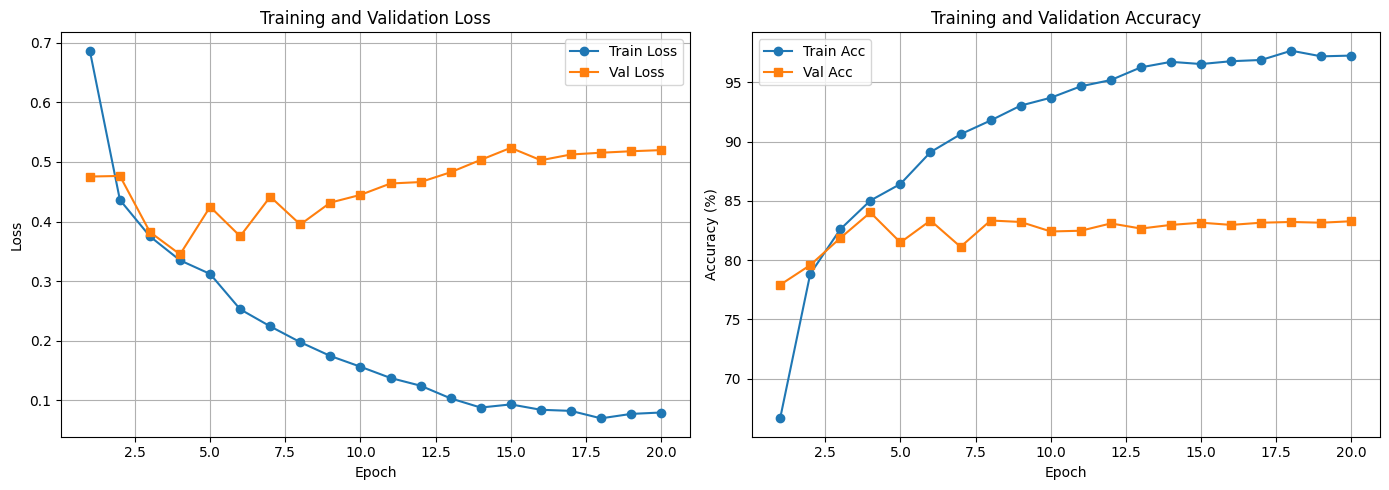

Training history saved to ./checkpoints/training_history.png


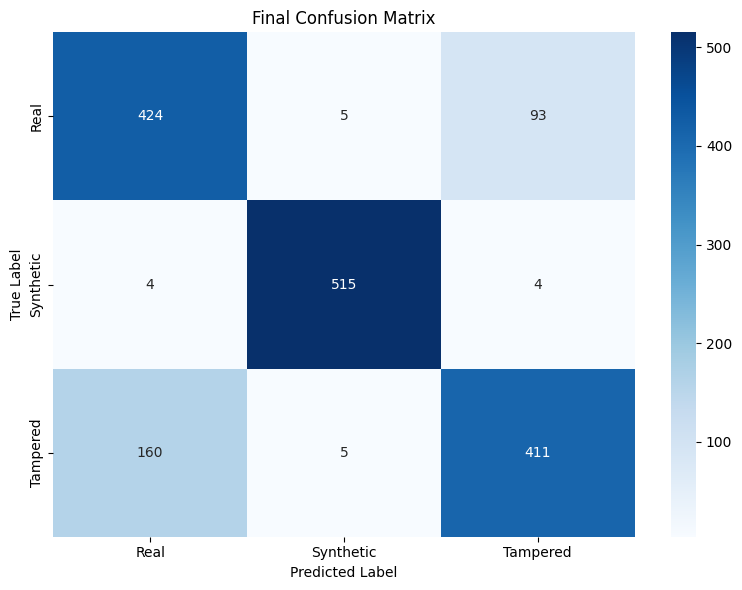

Confusion matrix saved to ./checkpoints/confusion_matrix.png


In [16]:
print("Generating plots...")

# Plot training history
plot_training_history(results, os.path.join(config.save_dir, 'training_history.png'))

# Plot final confusion matrix
plot_confusion_matrix(cm, os.path.join(config.save_dir, 'confusion_matrix.png'))

In [17]:
def evaluate_model_full(model, dataloader, device, class_names=['Real','Synthetic','Tampered'], set_name='Test'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{set_name} Evaluation"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.vstack(all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Overall accuracy
    acc = (all_labels == all_preds).mean() * 100

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_recall = recall_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_f1 = f1_score(all_labels, all_preds, labels=[0,1,2], average=None)

    # Macro metrics
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Weighted metrics
    weighted_precision = precision_score(all_labels, all_preds, average='weighted')
    weighted_recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    # AUC
    labels_onehot = np.zeros((all_labels.size, len(class_names)))
    labels_onehot[np.arange(all_labels.size), all_labels] = 1
    auc = roc_auc_score(labels_onehot, all_probs, average='macro')

    # Print metrics
    print(f"\n{'='*60}")
    print(f"{set_name} Metrics")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {acc:.2f}%")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall:    {macro_recall:.4f}")
    print(f"Macro F1:        {macro_f1:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall:    {weighted_recall:.4f}")
    print(f"Weighted F1:        {weighted_f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nPer-Class Metrics:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'macro': {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1},
        'weighted': {'precision': weighted_precision, 'recall': weighted_recall, 'f1': weighted_f1},
        'per_class': {cls: {'precision': per_class_precision[i], 'recall': per_class_recall[i], 'f1': per_class_f1[i]}
                      for i, cls in enumerate(class_names)},
        'auc': auc,
        'confusion_matrix': cm
    }

Test Evaluation:   0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Test Evaluation: 100%|██████████| 51/51 [01:14<00:00,  1.47s/it]



Test Metrics
Overall Accuracy: 83.02%
Macro Precision: 0.8318
Macro Recall:    0.8295
Macro F1:        0.8293
Weighted Precision: 0.8323
Weighted Recall:    0.8302
Weighted F1:        0.8299
AUC: 0.9463

Per-Class Metrics:
Real: Precision=0.7308, Recall=0.8078, F1=0.7673
Synthetic: Precision=0.9871, Recall=0.9816, F1=0.9843
Tampered: Precision=0.7775, Recall=0.6991, F1=0.7362


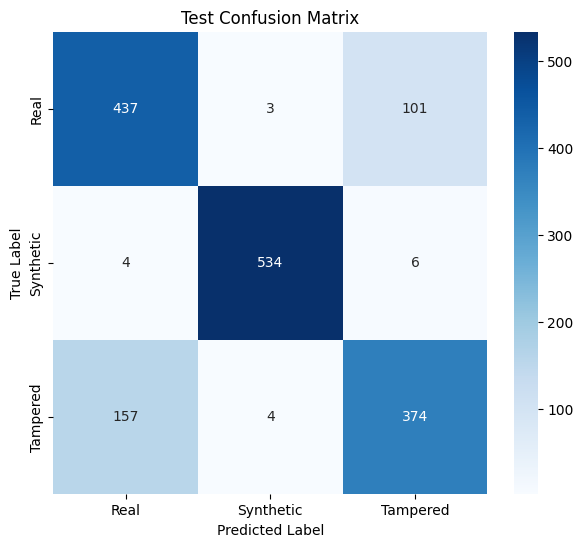

In [18]:
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

results = evaluate_model_full(model, test_loader, device, set_name='Test')
